# Import Modules

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from loguru import logger
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, PreTrainedTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

tqdm.pandas()


/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Prepare Dataset

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/deeptriage/gc_20_topics_kmeans.csv"

df = pd.read_csv(dataset_path)
df = df[df["owner"].notna()]

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True)
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.progress_apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

df = prepare_dataframe(df)
df = clean_data(df)

num_issues = len(df)

print(f"Total number of issues: {num_issues}")

100%|██████████| 109977/109977 [00:00<00:00, 120086.43it/s]


Total number of issues: 109977


In [3]:
df["topic_hot"] = pd.get_dummies(df["topic_label"]).values.tolist()

In [4]:
# Cross-Validation Fold Definition

num_cv = 10
sample_threshold=20 # Threshold to filter developers
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 1 
sliced_df = df[: samples_per_block * (block+1)]

Samples per block: 10998


In [5]:
# Train and Validation preparation

X_df = sliced_df[:samples_per_block*block]
y_df = sliced_df[samples_per_block*block : samples_per_block * (block+1)]

developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]

train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

unwanted = list(test_owners - train_owners)

y_df = y_df[~y_df["owner"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")
print(f"Number of developers: {len(X_df.owner.unique())}")

Training data: 7030, Validation data: 6096
Number of developers: 168


In [6]:
# Label encode developers

lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

<Axes: >

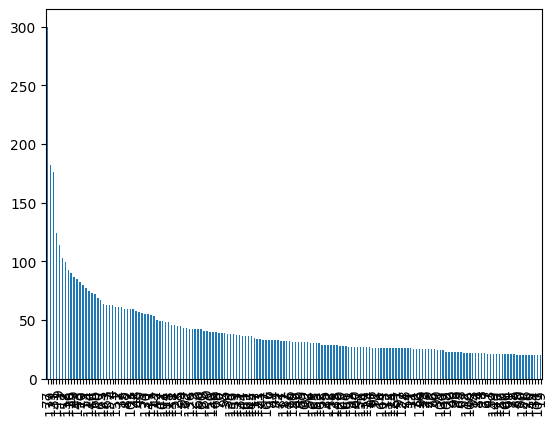

In [7]:
# Contribution plot

X_df.owner_id.value_counts().plot(kind="bar")

# Prepare PyTorch Dataset

In [8]:
class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        # self.embedding_model = SentenceTransformer("BAAI/bge-small-en")
        logger.debug("Tokenizing texts...")
        self.texts = [
            (row.text, self.tokenizer(
                row.text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ), torch.tensor(row.topic_hot))
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


# Transformer Model

In [9]:
class LBTPClassifierTopic(nn.Module):
    def __init__(
        self, output_size, topic_size, unfrozen_layers=4, embed_size=1024, dropout=0.1
    ) -> None:
        super().__init__()
        model_name = "microsoft/deberta-large"
        self.base_model = AutoModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, 24 - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = embed_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + topic_size, output_size
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, tok_type, topic_id):
        outputs = []

        base_out = self.base_model(input_ids=input_ids, token_type_ids=tok_type, attention_mask=attention_mask)
        # pooler_out = base_out.last_hidden_state.squeeze(0)
        hidden_states = base_out.hidden_states[-self.unfrozen_layers :]

        for i in range(self.unfrozen_layers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            # Concatanating outputs of the conv block of different filter sizes
            x = torch.cat(x, dim=1)
            x = self.dropout(x)
            x = torch.cat([x, topic_id], dim=1)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> AutoTokenizer:
        return self._tokenizer


# Loss Functions

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            focal_loss = focal_loss * self.alpha

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [11]:
class CombineLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss()

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

In [12]:
class CombineFocalLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._ce = FocalLoss()

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

# Training Parameters

In [13]:
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() # corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
weights_save_location = f"deberta_cv{block}.pt"

# Define hyperparameters
learning_rate = 1e-5
epochs = 12
batch_size = 15

model = LBTPClassifierTopic(len(X_df.owner_id.unique()), 20, dropout=0.3)
criterion = CombineLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.1, threshold=1e-8)

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
# Prepare torch dataset from train and validation splits
train = TriageDataset(X_df, model.tokenizer())
val = TriageDataset(y_df, model.tokenizer())

2024-03-02 10:03:12.128 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-03-02 10:03:12.130 | DEBUG    | __main__:__init__:13 - Tokenizing texts...
2024-03-02 10:03:18.775 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-03-02 10:03:18.779 | DEBUG    | __main__:__init__:13 - Tokenizing texts...


In [15]:
train_dataloader = DataLoader(
    dataset=train,
    batch_size=10,
    shuffle=False if sampler else True,
    sampler=sampler,
)
val_dataloader = DataLoader(val, batch_size=10)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_loss = float("inf")

if torch.cuda.is_available():
    logger.debug(f"Selected compute device: {device}")
    model = model.cuda()
    criterion = criterion.cuda()

2024-03-02 10:03:24.834 | DEBUG    | __main__:<module>:5 - Selected compute device: cuda


In [17]:
def log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
        topk,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Top 10: {topk} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"

        logger.info(log)

# Training Loop

In [18]:
model = model.cuda()

In [19]:
for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader, desc="Training Steps"):
        # print(train_input)
        train_label = train_label.to(device)
        mask = train_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = train_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = train_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = train_input[2].to(device)
        # print(tok_type.shape, input_id.shape, mask.shape)
        # print(repr.dtype, input_id.dtype, mask.dtype)

        output = model(input_id, mask, tok_type, repr)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        output = torch.sum(torch.stack(output), 0)
        acc = (output.argmax(dim=1) == train_label).sum().item()
        
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_acc_val = 0
    total_loss_val = 0
    correct_top_k = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for val_input, val_label in tqdm(val_dataloader, desc="Validation Steps"):
            val_label = val_label.to(device)
            mask = val_input[1]["attention_mask"].squeeze(1).to(device)
            input_id = val_input[1]["input_ids"].squeeze(1).to(device)
            tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
            repr = val_input[2].to(device)

            output = model(input_id, mask, tok_type, repr)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()

            output = torch.sum(torch.stack(output), 0)
            _, top_k_predictions = output.topk(10, 1, True, True)

            top_k_predictions = top_k_predictions.t()

            correct_top_k += (
                top_k_predictions.eq(
                    val_label.view(1, -1).expand_as(top_k_predictions)
                )
                .sum()
                .item()
            )

            acc = (output.argmax(dim=1) == val_label).sum().item()

            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(val_label.cpu().numpy())

            total_acc_val += acc

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )

    top10 = correct_top_k / len(y_df)

    log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        X_df,
        y_df,
        top10,
    )

    val_loss = total_loss_val / len(y_df)

    if scheduler:
        scheduler.step(val_loss)

    if val_loss < best_loss:
        logger.success("Found new best model. Saving weights...")
        torch.save(model.state_dict(), weights_save_location)
        best_loss = val_loss

Training Steps:   0%|          | 0/703 [00:00<?, ?it/s]

Training Steps:  14%|█▍        | 100/703 [01:32<09:15,  1.09it/s]


KeyboardInterrupt: 

# Evaluation

In [ ]:
# Load best checkpoint
model.load_state_dict(torch.load(weights_save_location))

In [ ]:
loader = DataLoader(val, 30)

In [ ]:
# Load embeddings for all train data
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
all_embeddings = similarity_model.encode(X_df.issue_title.to_list(), batch_size=15)

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
def get_top_k_similar_devs(issues, k=5, threshold=0.65):
    test_embed = similarity_model.encode(issues)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk_values, topk_indices = torch.topk(cos, k=k)
    
    similarities = []
    
    for idx, sim_score in zip(topk_indices, topk_values):
        sim_threshold = sim_score >= threshold
        filtered_idx = idx[sim_threshold].numpy()
        similarities.append(X_df.iloc[filtered_idx]["owner_id"].unique().tolist())

    return similarities

In [ ]:
total_acc_val = 0
total_loss_val = 0
correct_top_k = 0
correct_top_k_wo_sim = 0

all_preds = []
all_labels = []
device="cuda"

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = val_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = val_input[2].to(device)

        output = model(input_id, mask, tok_type, repr)



        output = torch.sum(torch.stack(output), 0)

        #wo similarity
        _, top_k_wo_sim = output.topk(10, 1, True, True)

        top_k_wo_sim = top_k_wo_sim.t()

        correct_top_k_wo_sim += (
            top_k_wo_sim.eq(
                val_label.view(1, -1).expand_as(top_k_wo_sim)
            )
            .sum()
            .item()
        )


        # with similarity
        _, top_k_predictions = output.topk(10, 1, True, True)
        similar_preds = get_top_k_similar_devs(val_input[0], k=5)

        unique_preds = []

        for top, sim in zip(top_k_predictions, similar_preds):
            # print(top, sim)
            
            copy_pred = top.cpu().numpy().tolist()
            top_preds = top.cpu().numpy().tolist()[:5]

            for s in sim:
                if s not in top_preds:
                    top_preds.append(s)
            
            if len(top_preds) < 10:
                top_preds = top_preds + copy_pred[5:5 + 10 - len(top_preds)]
            
            unique_preds.append(top_preds)

        unique_preds = torch.tensor(unique_preds).cuda()
        top_k_predictions = unique_preds.t()

        correct_top_k += (
            top_k_predictions.eq(
                val_label.view(1, -1).expand_as(top_k_predictions)
            )
            .sum()
            .item()
        )

        # break

        acc = (output.argmax(dim=1) == val_label).sum().item()

        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(val_label.cpu().numpy())

        total_acc_val += acc

In [ ]:
print(f"Correct Prediction without Similarity: {correct_top_k_wo_sim}, {correct_top_k_wo_sim / len(y_df)}")
print(f"Correct Prediction with Similarity: {correct_top_k}, {correct_top_k / len(y_df)}")

Correct Prediction without Similarity: 4315, 0.7078412073490814
Correct Prediction with Similarity: 4326, 0.7096456692913385


In [ ]:
all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)

# Result Analysis

In [ ]:
print(classification_report(all_labels_np, all_preds_np, target_names=labels))

In [ ]:
idx2label = {
    row["owner_id"]: row["owner"]
    for _, row in y_df.iterrows()
}

labels = y_df.owner_id.to_list()
labels = sorted(set(labels))
labels = [f"{idx}: {idx2label[idx]}" for idx in labels]

In [ ]:
def get_topic_distribution(owner):
    print("Training topic distribution")
    print("=======================================")
    print(X_df[X_df.owner == owner].topic_label.value_counts())

    print("\n\nTesting topic distribution")
    print("=======================================")
    print(y_df[y_df.owner == owner].topic_label.value_counts())

In [ ]:
X_df.topic_label.value_counts()

Chrome Tab and Window Behavior Issues     947
Build failures                            840
Chrome stability issues                   487
Layout Testing Issues                     400
Chrome crash reports                      391
Security and SSL issues                   372
Input and keyboard issues                 370
Webpage rendering regression issues       357
Chrome sync issues                        354
Shill WiFi configuration                  337
iOS File Issues                           321
Data Enhancement                          298
Touch and Scroll Issues                   273
DevTools Crashes                          260
GPU rendering issues                      235
Memory Leaks in WebCore and Blink         220
Performance testing issues in Chromium    197
WebRTC audio/video issues                 184
Bookmark issues                           174
Performance Regression in Blink            13
Name: topic_label, dtype: int64

In [ ]:
get_topic_distribution("a...@chromium.org")

Training topic distribution
Chrome Tab and Window Behavior Issues     10
Webpage rendering regression issues        5
Memory Leaks in WebCore and Blink          4
Chrome stability issues                    4
DevTools Crashes                           3
Data Enhancement                           3
Input and keyboard issues                  3
Touch and Scroll Issues                    2
Bookmark issues                            1
Security and SSL issues                    1
Chrome sync issues                         1
Layout Testing Issues                      1
Build failures                             1
iOS File Issues                            1
Performance testing issues in Chromium     1
Name: topic_label, dtype: int64


Testing topic distribution
Chrome Tab and Window Behavior Issues     17
Webpage rendering regression issues        7
DevTools Crashes                           6
iOS File Issues                            6
Touch and Scroll Issues                    4
Input and k